In [1]:
!nvidia-smi

Sat Oct 22 10:35:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [6]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
 
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [8]:
train_samples=preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples=preprocess_text_with_line_numbers(data_dir+'test.txt')
len(train_samples)

180040

In [9]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

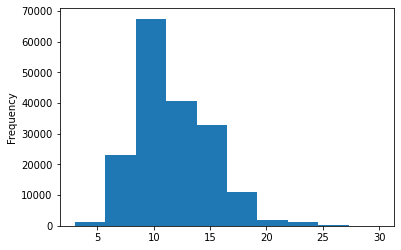

In [12]:
train_df.total_lines.plot.hist()

In [13]:
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_label_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1)) 

train_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
import tensorflow as tf
tf.constant(train_label_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded=label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded=label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [19]:
model_0=Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

In [20]:
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-10-22 10:35:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-22 10:35:48 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

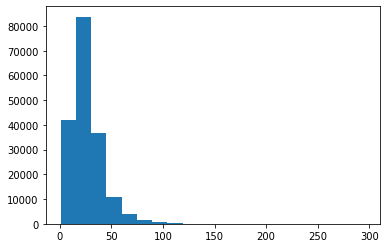

In [27]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [28]:
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [29]:
max_tokens=68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=output_seq_len)

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
import random
target_sentence=random.choice(train_sentences)
print(f'\nText:{target_sentence}')
print(f'\nLength:{len(target_sentence.split())}')
print(f'\nVectorized Text:{text_vectorizer([target_sentence])}')


Text:baseline characteristics did not differ between mono and triple-therapy groups , except for ethnicity ( p = @ ) .

Length:20

Vectorized Text:[[   49   395   112    31   544    30 18354     3 21496    24  1081    11
   4383    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f'Number of words in the text vocab:{len(rct_20k_text_vocab)}')
print(f'The most common words in the vocab:{rct_20k_text_vocab[:5]}')
print(f'The least common words in the vocab:{rct_20k_text_vocab[-5:]}')

Number of words in the text vocab:64841
The most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
The least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True,
                             name='token_embedding')

In [34]:
print(f'The sentence before vectorization:\n{target_sentence}')
vectorized_sentence=text_vectorizer([target_sentence])
print(f'\nSentence after vectorization before embedding:\n{vectorized_sentence}')
embedded_sentence=token_embed(vectorized_sentence)
print(f'\nThe sentence after embedding :\n{embedded_sentence} ')
print(f'The embedded sentence shape is:{embedded_sentence.shape}')

The sentence before vectorization:
baseline characteristics did not differ between mono and triple-therapy groups , except for ethnicity ( p = @ ) .

Sentence after vectorization before embedding:
[[   49   395   112    31   544    30 18354     3 21496    24  1081    11
   4383    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

The sentence after embedding :
[[[ 0.03432146  0.04833194 -0.03787177 ... -0.03935434  0.02365978
    0.00526723]
  [-0.00328022  0.03077013  0.04613497 ... -0.02612884  0.01686834
   -0.00895041]
  [ 0.04516876  0.04061902  0.00141791 ... -0.01148987  0.04236363
   -0.00423645]
  ...
  [-0.01072167 -0.02690491  0.01436527 ... -0.03069968  0.04905957
    0.00055017]
  [-0.01072167 -0.02690491  0.01436527 ... -0.03069968  0.04905957
    0.00055017]
  [-0.01

In [35]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_label_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_label_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_label_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [37]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vector=text_vectorizer(inputs)
token_embeddings=token_embed(text_vector)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(inputs,outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=val_dataset,
                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9116 - accuracy: 0.6423 - val_loss: 0.6791 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6536 - accuracy: 0.7602 - val_loss: 0.6267 - val_accuracy: 0.7739
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6144 - accuracy: 0.7766 - val_loss: 0.5920 - val_accuracy: 0.7872


In [40]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5940 - accuracy: 0.7884


[0.5940403342247009, 0.7883622646331787]

In [41]:
model_1_pred_probs=model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.6837345e-01, 1.6183913e-01, 8.6167224e-02, 2.5215793e-01,
        3.1462267e-02],
       [4.1539019e-01, 3.1333292e-01, 1.5857263e-02, 2.4570441e-01,
        9.7152311e-03],
       [1.3306445e-01, 7.6448498e-03, 1.8995060e-03, 8.5734701e-01,
        4.4242126e-05],
       ...,
       [9.5349887e-06, 5.9123011e-04, 8.7415532e-04, 3.6414938e-06,
        9.9852151e-01],
       [5.0958246e-02, 4.8817074e-01, 8.3937980e-02, 5.6610584e-02,
        3.2032251e-01],
       [1.6095220e-01, 6.7223215e-01, 5.4067656e-02, 4.6668183e-02,
        6.6079855e-02]], dtype=float32)

In [42]:
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.83622401694691,
 'precision': 0.7854773226817365,
 'recall': 0.7883622401694691,
 'f1': 0.7859365985721446}

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='universal_sentence_encoder')

In [45]:
random_train_sentence=random.choice(train_sentences)
print(f'Random sentence:\n{random_train_sentence}')
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f'The sentence after embedding:\n{use_embedded_sentence}\n')
print(f'The length of sentence embedding:{len(use_embedded_sentence)}')

Random sentence:
addition of fluorouracil led to increased rates of grade @-@ neutropenia ( @ -lsb- @ % -rsb- of @ patients on fec-p vs @ -lsb- @ % -rsb- of @ patients on ec-p ; p < @ ) , fever ( nine -lsb- @ % -rsb- vs two -lsb- @ % -rsb- ) , nausea ( @ -lsb- @ % -rsb- vs @ -lsb- @ % -rsb- ) , and vomiting ( @ -lsb- @ % -rsb- vs @ -lsb- @ % -rsb- ) .
The sentence after embedding:
[[-0.05711401 -0.06111713 -0.05155459 -0.02724368  0.04004087 -0.06667265
  -0.03825795  0.01418095  0.05022116  0.05492916  0.06718415 -0.06521067
   0.04833929  0.0546696   0.02575306  0.04085495 -0.0682964  -0.06766193
  -0.03423633  0.02003551  0.06555131  0.0300934  -0.03240958 -0.05179887
   0.04398164  0.03864494  0.03455962 -0.00096131  0.00076757 -0.03474013
   0.06146695  0.06797409 -0.03640499 -0.04590534 -0.05408147  0.03213567
   0.04293627 -0.0238275  -0.04996159 -0.00728828  0.06054453  0.0609596
  -0.01126896 -0.04530911  0.06255511  0.04376354  0.01546848 -0.01204202
  -0.03692164  0.04232053

In [46]:
inputs=layers.Input(shape=[ ],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_2=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name='model_2_USE_feature_extractor')

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [47]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [48]:
history_model_2=model_2.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=val_dataset,
                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9185 - accuracy: 0.6492 - val_loss: 0.7971 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7695 - accuracy: 0.7012 - val_loss: 0.7538 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7525 - accuracy: 0.7116 - val_loss: 0.7379 - val_accuracy: 0.7144


In [49]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7416 - accuracy: 0.7134


[0.7416427731513977, 0.7134250998497009]

In [50]:
model_2_pred_probs=model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[0.45477965, 0.36448604, 0.00228243, 0.17018299, 0.00826888],
       [0.37074208, 0.48324552, 0.00361142, 0.13955118, 0.00284983],
       [0.22615924, 0.15680777, 0.01676403, 0.5572501 , 0.04301885],
       ...,
       [0.00261117, 0.00595282, 0.05827335, 0.00098864, 0.932174  ],
       [0.00391953, 0.04474786, 0.16955176, 0.00159167, 0.78018916],
       [0.17058082, 0.2639702 , 0.49192163, 0.0067298 , 0.06679761]],
      dtype=float32)

In [51]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [52]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.34251290877796,
 'precision': 0.7137792750367241,
 'recall': 0.7134251290877797,
 'f1': 0.7106544838236133}

In [53]:
def split_chars(text):
  return " ".join(list(text))

In [54]:
split_chars(random_train_sentence)

'a d d i t i o n   o f   f l u o r o u r a c i l   l e d   t o   i n c r e a s e d   r a t e s   o f   g r a d e   @ - @   n e u t r o p e n i a   (   @   - l s b -   @   %   - r s b -   o f   @   p a t i e n t s   o n   f e c - p   v s   @   - l s b -   @   %   - r s b -   o f   @   p a t i e n t s   o n   e c - p   ;   p   <   @   )   ,   f e v e r   (   n i n e   - l s b -   @   %   - r s b -   v s   t w o   - l s b -   @   %   - r s b -   )   ,   n a u s e a   (   @   - l s b -   @   %   - r s b -   v s   @   - l s b -   @   %   - r s b -   )   ,   a n d   v o m i t i n g   (   @   - l s b -   @   %   - r s b -   v s   @   - l s b -   @   %   - r s b -   )   .'

In [55]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [56]:
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [57]:
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_lens=np.mean(char_lens)
mean_char_lens

149.3662574983337

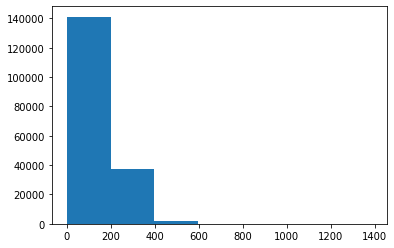

In [58]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [59]:
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [60]:
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
NUM_CHAR_TOKENS=len(alphabet)+2
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [62]:
char_vectorizer.adapt(train_chars)

In [63]:
char_vocab=char_vectorizer.get_vocabulary()
print(f'Num of chars in char vectorizer:{len(char_vocab)}')
print(f'The 5 most common characters:{char_vocab[:5]}')
print(f'The least 5 common characters:{char_vocab[-5:]}')

Num of chars in char vectorizer:28
The 5 most common characters:['', '[UNK]', 'e', 't', 'i']
The least 5 common characters:['k', 'x', 'z', 'q', 'j']


In [64]:
random_train_chars=random.choice(train_chars)
print(f'Charified text:{random_train_chars}')
print(f'Length of random train chars:{len(random_train_chars.split())}')
vectorized_chars=char_vectorizer([random_train_chars])

Charified text:s a f e t y   a n d   i m m u n o g e n i c i t y   o f   s a b i n - i p v   (   s i p v   )   w a s   e v a l u a t e d   i n   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   c o n t r o l l e d   ,   d o s e - e s c a l a t i o n   t r i a l   i n   t h e   t a r g e t   p o p u l a t i o n   .
Length of random train chars:132


In [65]:
print(f'Vectorized chars:\n{vectorized_chars}')
print(f'Length of vectorized chars:{len(vectorized_chars[0])}')

Vectorized chars:
[[ 9  5 17  2  3 19  5  6 10  4 15 15 16  6  7 18  2  6  4 11  4  3 19  7
  17  9  5 22  4  6  4 14 21  9  4 14 21 20  5  9  2 21  5 12 16  5  3  2
  10  4  6  5 10  7 16 22 12  2 22 12  4  6 10  8  5  6 10  7 15  4 25  2
  10 11  7  6  3  8  7 12 12  2 10 10  7  9  2  2  9 11  5 12  5  3  4  7
   6  3  8  4  5 12  4  6  3 13  2  3  5  8 18  2  3 14  7 14 16 12  5  3
   4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
Length of vectorized chars:290


In [66]:
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25,
                            mask_zero=True,
                            name='char_embedding')

In [67]:
print(f'Charified text:{random_train_chars}')
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded characters:\n{char_embed_example}')

Charified text:s a f e t y   a n d   i m m u n o g e n i c i t y   o f   s a b i n - i p v   (   s i p v   )   w a s   e v a l u a t e d   i n   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   c o n t r o l l e d   ,   d o s e - e s c a l a t i o n   t r i a l   i n   t h e   t a r g e t   p o p u l a t i o n   .
Embedded characters:
[[[ 0.01510713  0.01812952 -0.01552372 ... -0.01177267 -0.00331189
    0.03841144]
  [ 0.00245346 -0.0030448   0.04569406 ... -0.02328975  0.00596671
    0.03916461]
  [ 0.02903645 -0.04217637  0.04424686 ...  0.04444057  0.04112574
    0.00167738]
  ...
  [ 0.03778379 -0.0472604  -0.03324006 ...  0.04124818  0.01903563
    0.04691506]
  [ 0.03778379 -0.0472604  -0.03324006 ...  0.04124818  0.01903563
    0.04691506]
  [ 0.03778379 -0.0472604  -0.03324006 ...  0.04124818  0.01903563
    0.04691506]]]


In [68]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name='model_3_char_embeddings_conv1D')

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [69]:
model_3.summary()

Model: "model_3_char_embeddings_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [70]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2561 - accuracy: 0.4863 - val_loss: 1.0460 - val_accuracy: 0.5788
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0125 - accuracy: 0.5917 - val_loss: 0.9476 - val_accuracy: 0.6310
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9283 - accuracy: 0.6348 - val_loss: 0.8671 - val_accuracy: 0.6652


In [72]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8853 - accuracy: 0.6588


[0.8853045105934143, 0.6587779521942139]

In [73]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.14676987, 0.312081  , 0.34775248, 0.12058051, 0.07281609],
       [0.2905223 , 0.4405652 , 0.03017684, 0.17581378, 0.06292191],
       [0.1692567 , 0.2774355 , 0.15065975, 0.31043   , 0.09221802],
       ...,
       [0.03592894, 0.03908475, 0.11720178, 0.03560134, 0.7721832 ],
       [0.05385218, 0.20094922, 0.43886754, 0.03225378, 0.2740773 ],
       [0.36555138, 0.396777  , 0.16314197, 0.04251881, 0.03201082]],
      dtype=float32)

In [74]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 1, 3, ..., 4, 2, 1])>

In [75]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.87779690189329,
 'precision': 0.6529704245568232,
 'recall': 0.6587779690189329,
 'f1': 0.6487224868370766}

In [76]:
token_inputs=layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


In [77]:
token_char_concat=layers.Concatenate(name='token_char_inputs')([token_model.output,
                                                           char_model.output])
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [78]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

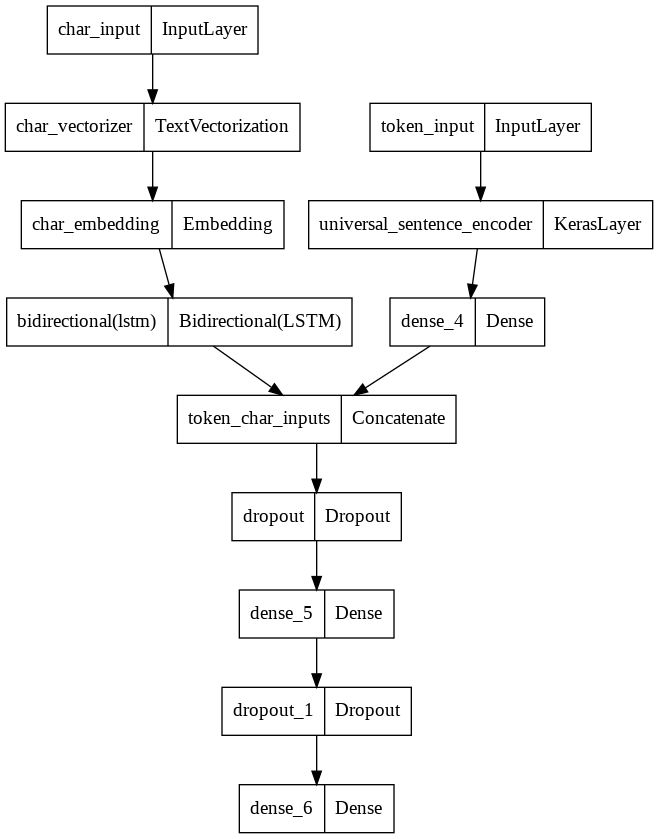

In [79]:
from keras.utils import plot_model
plot_model(model_4) 

In [80]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [81]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [82]:
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 51ms/step - loss: 0.9835 - accuracy: 0.6097 - val_loss: 0.7778 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.8096 - accuracy: 0.6876 - val_loss: 0.7185 - val_accuracy: 0.7294
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.7733 - accuracy: 0.7036 - val_loss: 0.6900 - val_accuracy: 0.7417


In [83]:
model_4.evaluate(val_char_token_dataset)
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 22s 21ms/step


{'accuracy': 73.60320402489077,
 'precision': 0.7362764258721541,
 'recall': 0.7360320402489077,
 'f1': 0.7329863675960849}

In [84]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [85]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [87]:
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
train_line_numbers_one_hot[:15]

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

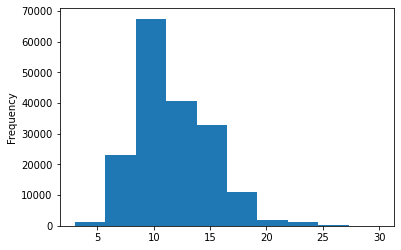

In [88]:
train_df['total_lines'].plot.hist()

In [89]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


In [90]:
token_inputs=layers.Input(shape=[],dtype=tf.string,name='token_inputs')
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs=layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
line_number_dense=layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=total_lines_dense)

In [94]:

combined_embeddings=layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                             char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
tribrid_embeddings=layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                               total_line_model.output,
                                                                               z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [95]:
 model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

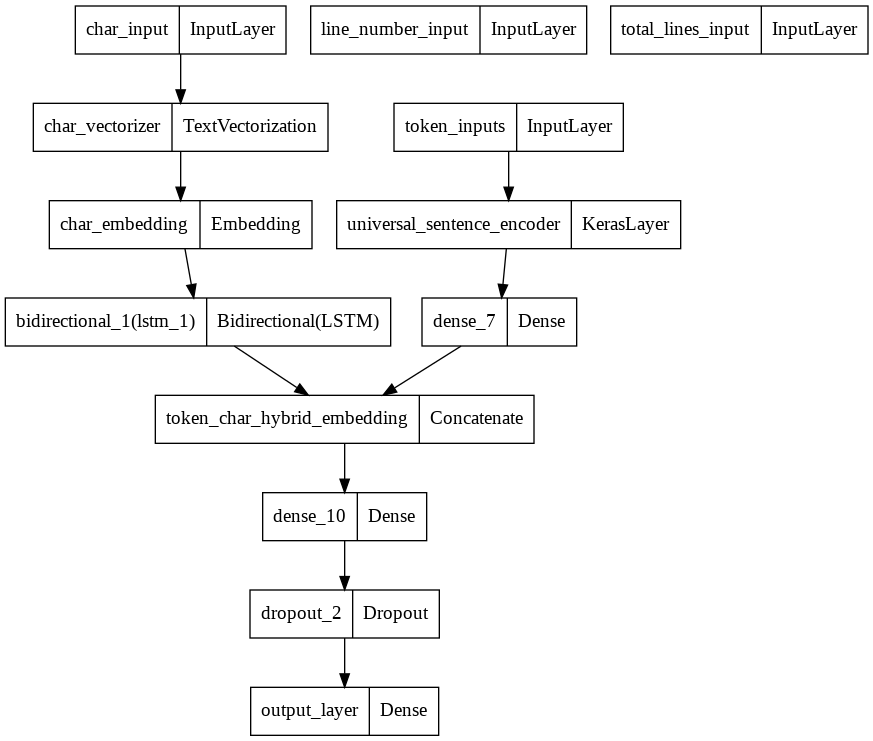

In [97]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [98]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [100]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [103]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 48ms/step - loss: 1.0500 - accuracy: 0.7543 - val_loss: 1.0354 - val_accuracy: 0.7643
Epoch 2/3
562/562 [==============================] - 27s 47ms/step - loss: 1.0312 - accuracy: 0.7652 - val_loss: 1.0225 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 1.0259 - accuracy: 0.7661 - val_loss: 1.0181 - val_accuracy: 0.7703


In [104]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 20s 21ms/step


{'accuracy': 76.53250364093738,
 'precision': 0.7631457055995209,
 'recall': 0.7653250364093738,
 'f1': 0.7629751209172574}